# Modeling

## Base Model

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join(os.pardir, 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules import dataloading as dl
from modules import VizFig
from modules import modeling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import sklearn.preprocessing as skp

targetdir = "../data/extracted/"
figtargetdir = "../images/"

df = pd.read_stata(targetdir + 'scf2019s/p19i6.dta', columns=dl.sel_vars)
df.columns = [x.lower() for x in df.columns]
df.rename(columns=dl.rename_dict, inplace=True)
df = dl.clean_SCF_df(df, neg_vals=False, modeling=True)

In [2]:
sets = modeling.baseline(targetdir)

In [3]:
sets['F1']

0.9079854073773814

In [4]:
sets = modeling.weighted(targetdir)
sets['F1']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.0s finished


0.915

In [5]:
sets = modeling.weightandscale(targetdir)
sets['F1']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


0.912106135986733

In [121]:
sets = modeling.weightandscale(targetdir, iqr=(.1,99.9))
sets['metrics']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.7s finished


{'F1': 0.9158723580605057,
 'Precision': 0.9020408163265307,
 'Recall': 0.9301346801346801,
 'AUC': 0.8999102569141479}

In [119]:
sets = modeling.weightandscale(targetdir, iqr=(.1,77), improved_params=True)
print(sets['metrics'])
sets['model']['grid'].best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s


{'F1': 0.9172932330827067, 'Precision': 0.8655713218820015, 'Recall': 0.9755892255892256, 'AUC': 0.8810707594754288}


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.3s finished


{'C': 1e-05, 'max_iter': 1000, 'penalty': 'l2'}

### Train-test Split

In [10]:
y = df['1k_target']
y.head()

household_id
1    1
2    0
3    1
4    1
5    0
Name: 1k_target, dtype: int64

In [11]:
X = df.drop(labels='1k_target', axis=1, inplace=False)
X.head()

,persons_in_PEU,ref_age,spouse_age,total_income,total_cc_limit,freq_cc_payment,rev_charge_accts,num_fin_inst,LOC_owed_now,ed_loans_owed_now,...,spouse_occ_code_2.0,spouse_occ_code_3.0,spouse_occ_code_4.0,spouse_occ_code_5.0,spouse_occ_code_6.0,primary_home_type_3.0,primary_home_type_4.0,primary_home_type_5.0,income_comparison_2.0,income_comparison_3.0
household_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,75.0,0.0,52800.0,15000.0,1.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
2,5.0,50.0,39.0,37800.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
3,2.0,53.0,49.0,103000.0,1000.0,3.0,0.0,2.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
4,2.0,29.0,28.0,122000.0,55000.0,1.0,0.0,10.0,0.0,177000.0,...,0,0,0,0,0,1,0,0,0,1
5,2.0,47.0,39.0,29200.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0


In [12]:
w_df = pd.read_stata(targetdir + 'scf2019s/p19i6.dta', columns=dl.sel_vars)
w_df.columns = [x.lower() for x in w_df.columns]
w_df.rename(columns=dl.rename_dict, inplace=True)
w_df = dl.clean_SCF_df(w_df, neg_vals=False, modeling=False)
w = w_df.weighting


## Unweighted Logistic Reg (Base Model)

In [13]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, random_state=1)

logreg = LogisticRegression(max_iter=1000)

# Fit to train data
logreg.fit(X_train, y_train)

#use the fitted model to predict on the test data
lr_preds = logreg.predict(X_test)

lr_f1 = metrics.f1_score(y_test, lr_preds)
lr_prec = metrics.precision_score(y_test, lr_preds)
lr_rec = metrics.recall_score(y_test, lr_preds)

# checking accuracy on the test data
print('Test F1 score: ', lr_f1)
print('Test Precision score: ', lr_prec)
print('Test Recall score: ', lr_f1)



Test F1 score:  0.9079854073773814
Test Precision score:  0.8756841282251759
Test Recall score:  0.9079854073773814


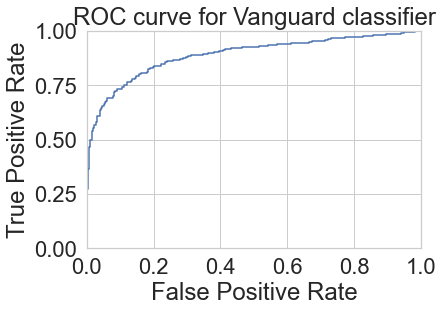

In [14]:
import matplotlib.pyplot as plt

# getting the probability predicitons
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Vanguard classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [15]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8891017830706547


In [16]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [metrics.f1_score(y_test, to_labels(y_pred_prob, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.541, F-Score=0.91405


This base model utilized unweighted samples from the dataset to generate a base model. As such, this unweighted model will overtrain on more well-off households given the survey methods of this data. As such, the model will likely over-predict the number of people that are in the target class. This can be seen in the relatively lower precision score compared to the recall score and also by the fact that an increase in the threshold leads to better scores.

If the model were trained using the sample weights provided by the Survey of Consumer finances, one would expect the precision to improve and therefore improve the F1 score.

## Using "sample weight" on fit

As predicted, using sample weights helped improve the F1 score by approximately .008. The best F1 score that the model could achieve by adjusting the threshold is .917, or about a .01 increase compared to baseline. 

This can be attributed to the weighting taking into account the oversampling of well-off households and taking those classification with mathematical grain of salt. As such, it should receive less false positives, as confirmed by the increase in the precision score from .875 to .901. 

Across all thresholds, however, the weighted model only performs slightly better: the AUC increased by .005.

In [17]:
logreg = LogisticRegression(max_iter=5000)
# scalar = MinMaxScaler()
# X_train = scalar.fit_transform(X_train)
# X_test = scalar.transform(X_test)


# Fit to train data
logreg.fit(X_train, y_train, sample_weight=w_train)

#use the fitted model to predict on the test data
lr_preds = logreg.predict(X_test)

lr_f1 = metrics.f1_score(y_test, lr_preds)

# checking accuracy on the test data
print('Test F1 score: ', lr_f1)

Test F1 score:  0.915


In [18]:
# grid search
param_grid = { 
    'penalty': ['l2'],
    'C': [.00001, .0001, .001, .01, .1, 1, 10, 100],
    'max_iter': [1000]
}

#create a grid search object and fit it to the data

grid_lr=GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_lr.fit(X_train, y_train, sample_weight=w_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring='f1', verbose=1)

In [19]:
### Identify the best params 

# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)
#Identify the best score during fitting with cross-validation

#Predict the response for test dataset
y_pred = grid_lr.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


0.9044951721060261
{'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
LogisticRegression(C=1, max_iter=1000)
F1: 0.915
Precision: 0.905940594059406
Recall: 0.9242424242424242


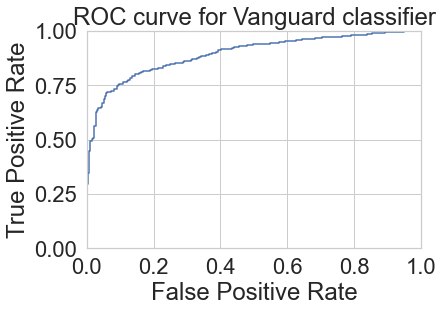

In [20]:
import matplotlib.pyplot as plt

# getting the probability predicitons
y_pred_prob = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Vanguard classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [21]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8939623210051224


In [22]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [metrics.f1_score(y_test, to_labels(y_pred_prob, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.491, F-Score=0.91715


### *Feature importance for weighted model*

In [23]:
coef_ = sorted(list(zip(X.columns.to_list(), grid_lr.best_estimator_.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_negative = coef_[-5:]
top_10_features = top_5_positive + top_5_negative
top_10_df = pd.DataFrame(top_10_features, columns=['Features', 'LogRegCoeff'])

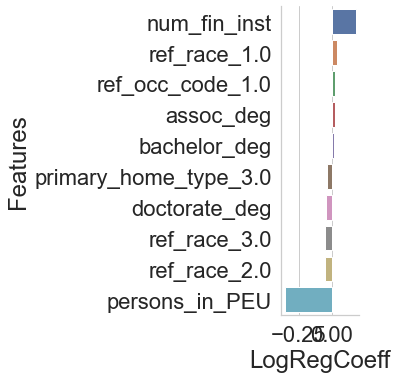

In [24]:
fig = sns.catplot(data=top_10_df,
                x='LogRegCoeff',
                y='Features',
                orient='h',
                  kind='bar'
               )

Surprisingly the highest indicator for having liquid assets is the `num_fin_inst`.

## Weighting and RobustScaling

In [25]:
logreg = LogisticRegression(max_iter=5000)
scalar = skp.RobustScaler()
X = df.drop(labels='1k_target', axis=1, inplace=False)
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


# Fit to train data
logreg.fit(X_train, y_train, sample_weight=w_train)

#use the fitted model to predict on the test data
lr_preds = logreg.predict(X_test)

lr_f1 = metrics.f1_score(y_test, lr_preds)

# checking accuracy on the test data
print('Test F1 score: ', lr_f1)

Test F1 score:  0.912106135986733


In [26]:
# grid search
param_grid = { 
    'penalty': ['l2'],
    'C': [.00001, .0001, .001, .01, .1, 1, 10, 100],
    'max_iter': [1000]
}

#create a grid search object and fit it to the data

grid_lr=GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_lr.fit(X_train, y_train, sample_weight=w_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring='f1', verbose=1)

In [27]:
### Identify the best params 

# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)
#Identify the best score during fitting with cross-validation

#Predict the response for test dataset
y_pred = grid_lr.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

0.9114373329432872
{'C': 10, 'max_iter': 1000, 'penalty': 'l2'}
LogisticRegression(C=10, max_iter=1000)
F1: 0.912106135986733
Precision: 0.8986928104575164
Recall: 0.9259259259259259


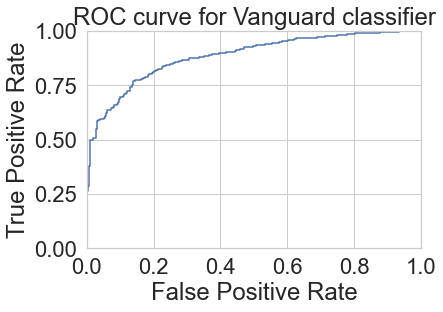

In [28]:
import matplotlib.pyplot as plt

# getting the probability predicitons
y_pred_prob = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Vanguard classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [29]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.884097132151607


In [30]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [metrics.f1_score(y_test, to_labels(y_pred_prob, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.392, F-Score=0.91907


### *Feature importance for weighted model*

In [31]:
coef_ = sorted(list(zip(X.columns.to_list(), grid_lr.best_estimator_.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_negative = coef_[-5:]
top_10_features = top_5_positive + top_5_negative
top_10_df = pd.DataFrame(top_10_features, columns=['Features', 'LogRegCoeff'])

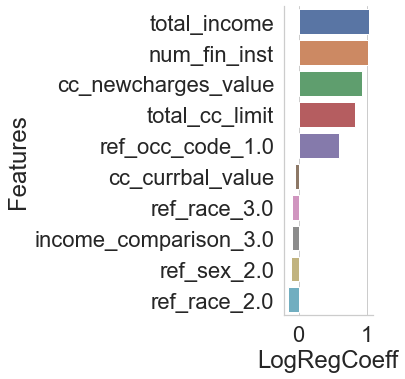

In [32]:
fig = sns.catplot(data=top_10_df,
                x='LogRegCoeff',
                y='Features',
                orient='h',
                  kind='bar'
               )

## RobustScaling tuning

In [33]:
logreg = LogisticRegression(max_iter=5000)
scalar = skp.RobustScaler(quantile_range=(0.1,99.9))
X = df.drop(labels='1k_target', axis=1, inplace=False)
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


# Fit to train data
logreg.fit(X_train, y_train, sample_weight=w_train)

#use the fitted model to predict on the test data
lr_preds = logreg.predict(X_test)

lr_f1 = metrics.f1_score(y_test, lr_preds)

# checking accuracy on the test data
print('Test F1 score: ', lr_f1)

Test F1 score:  0.916321458160729


In [34]:
# grid search
param_grid = { 
    'penalty': ['l2'],
    'C': [.00001, .0001, .001, .01, .1, 1, 10, 100],
    'max_iter': [5000]
}

#create a grid search object and fit it to the data

grid_lr=GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_lr.fit(X_train, y_train, sample_weight=w_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  40 | elapsed:    6.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [5000], 'penalty': ['l2']},
             scoring='f1', verbose=1)

In [35]:
### Identify the best params 

# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)
#Identify the best score during fitting with cross-validation

#Predict the response for test dataset
y_pred = grid_lr.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

0.9101447723365551
{'C': 100, 'max_iter': 5000, 'penalty': 'l2'}
LogisticRegression(C=100, max_iter=5000)
F1: 0.9149730402322687
Precision: 0.901880621422731
Recall: 0.9284511784511784


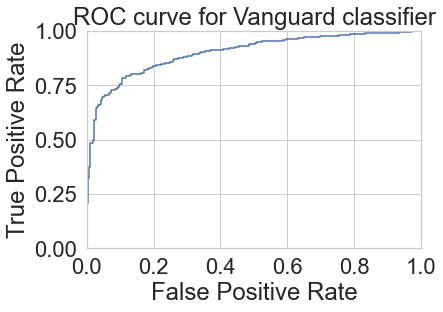

In [36]:
import matplotlib.pyplot as plt

# getting the probability predicitons
y_pred_prob = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Vanguard classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [37]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8999724875211257


In [38]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [metrics.f1_score(y_test, to_labels(y_pred_prob, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.452, F-Score=0.92150


### *Feature importance for weighted scale-tuned model*

In [39]:
coef_ = sorted(list(zip(X.columns.to_list(), grid_lr.best_estimator_.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_df = pd.DataFrame(top_5_positive, columns=['Features', 'LogRegCoeff'])

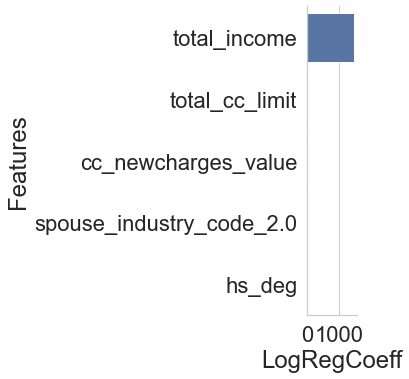

In [40]:
fig = sns.catplot(data=top_5_df,
                x='LogRegCoeff',
                y='Features',
                orient='h',
                  kind='bar'
               )

## Adjusting for outliers in robustscaler

In [41]:
logreg = LogisticRegression(max_iter=5000)
scalar = skp.RobustScaler(quantile_range=(0.1,60))
X = df.drop(labels=['1k_target'], axis=1, inplace=False)
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


# Fit to train data
logreg.fit(X_train, y_train, sample_weight=w_train)

#use the fitted model to predict on the test data
lr_preds = logreg.predict(X_test)

lr_f1 = metrics.f1_score(y_test, lr_preds)

# checking accuracy on the test data
print('Test F1 score: ', lr_f1)

Test F1 score:  0.9145228215767635


In [90]:
# grid search
param_grid = { 
    'penalty': ['l2'],
    'C': [.00001, .0001, .001, .01, .1, 1, 10, 100],
    'max_iter': [5000]
}

#create a grid search object and fit it to the data

grid_lr=GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_lr.fit(X_train, y_train, sample_weight=w_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [5000], 'penalty': ['l2']},
             scoring='f1', verbose=1)

In [91]:
### Identify the best params 

# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)
#Identify the best score during fitting with cross-validation

#Predict the response for test dataset
y_pred = grid_lr.best_estimator_.predict(X_test)

# Model F1, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

0.9044951721060261
{'C': 1, 'max_iter': 5000, 'penalty': 'l2'}
LogisticRegression(C=1, max_iter=5000)
F1: 0.915
Precision: 0.905940594059406
Recall: 0.9242424242424242


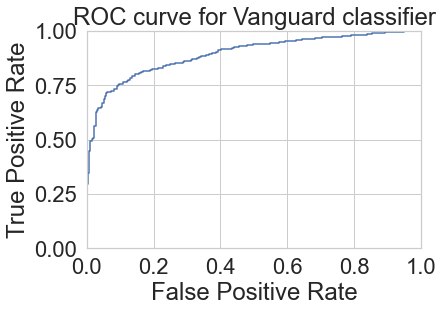

In [92]:
import matplotlib.pyplot as plt

# getting the probability predicitons
y_pred_prob = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Vanguard classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [93]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8939623210051224


In [94]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [metrics.f1_score(y_test, to_labels(y_pred_prob, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.491, F-Score=0.91715


### *Feature importance for weighted scale-tuned model*

In [95]:
coef_ = sorted(list(zip(X.columns.to_list(), grid_lr.best_estimator_.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_df = pd.DataFrame(top_5_positive, columns=['Features', 'LogRegCoeff'])

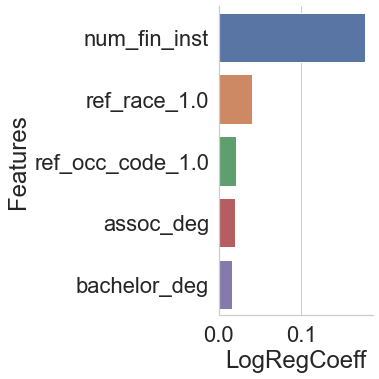

In [96]:
fig = sns.catplot(data=top_5_df,
                x='LogRegCoeff',
                y='Features',
                orient='h',
                  kind='bar'
               )

## Optimizing RobustScaler

In [102]:
sets = modeling.weightandscale(targetdir, iqr=(.1,60), improved_params=True)
print(sets['F1'])
sets['model']['grid'].best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    8.7s finished


0.9083155650319831


{'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2'}

In [103]:
coef_ = sorted(list(zip(sets['model']['sets']['orig']['X'].columns.to_list(), sets['model']['grid'].best_estimator_.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_df = pd.DataFrame(top_5_positive, columns=['Features', 'LogRegCoeff'])

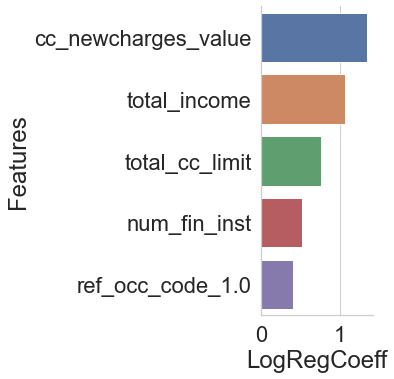

In [104]:
fig = sns.catplot(data=top_5_df,
                x='LogRegCoeff',
                y='Features',
                orient='h',
                  kind='bar'
               )

In [107]:
upper_q = list(range(50,99,1))

# evaluate each threshold
scores = [modeling.weightandscale(targetdir, iqr=(.1,q), improved_params=True)['F1'] for q in upper_q]
# get best threshold
ix = np.argmax(scores)
print('Upper Quantile=%.3f, F-Score=%.5f' % (upper_q[ix], scores[ix]))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    9.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.6s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.5s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.6s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.4s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.0s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.3s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.3s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.3s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.6s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.0s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.2s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.7s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.2s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.4s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.5s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.2s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.9s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.2s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.0s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.1s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.6s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.3s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.7s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.2s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   58.3s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   49.6s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   37.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   26.0s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   16.0s finished


Upper Quantile=77.000, F-Score=0.91729


/Users/danielvalenzuela/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [118]:
sets = modeling.weightandscale(targetdir, iqr=(.1,77), improved_params=True)
print(sets['metrics'])
sets['model']['grid'].best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s


{'F1': 0.9172932330827067, 'Precision': 0.8655713218820015, 'Recall': 0.9755892255892256, 'AUC': 0.8810707594754288}


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.3s finished


{'C': 1e-05, 'max_iter': 1000, 'penalty': 'l2'}

In [110]:
coef_ = sorted(list(zip(sets['model']['sets']['orig']['X'].columns.to_list(), sets['model']['grid'].best_estimator_.coef_[0])), key = lambda x: x[1], reverse=True)
top_5_positive = coef_[:5]
top_5_df = pd.DataFrame(top_5_positive, columns=['Features', 'LogRegCoeff'])

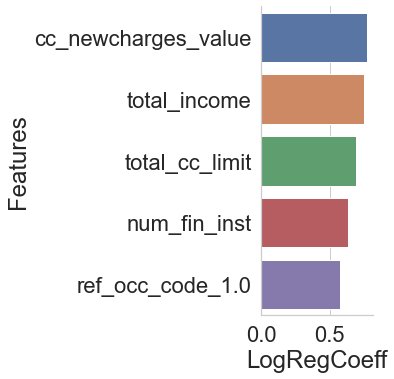

In [111]:
fig = sns.catplot(data=top_5_df,
                x='LogRegCoeff',
                y='Features',
                orient='h',
                  kind='bar'
               )

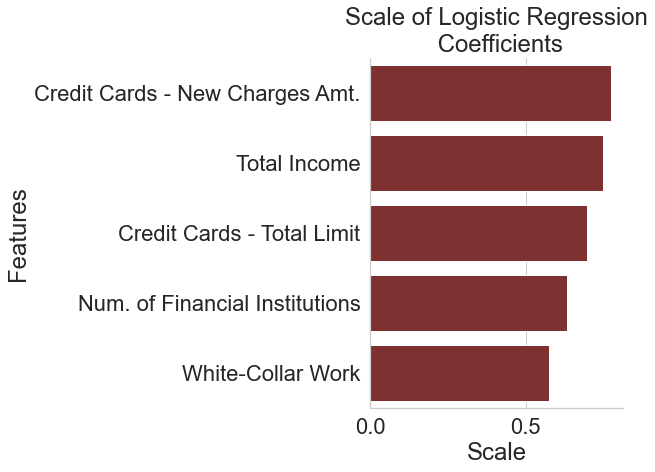

In [115]:
VizFig.PlotCatCoeff(top_5_df, xvar='LogRegCoeff', yvar='Features', kind='bar', targetdir=figtargetdir)